<a href="https://colab.research.google.com/github/pratik-99/Bone-Age-Prediction/blob/main/bone_age_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an attempt to predict bone age using Xception(pre trained model)<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries used

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

**Some Setup**<br>
The cell below creates the pandas dataframes for training and testing.

In [ ]:
#loading dataframes
train_df = pd.read_csv('/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-training-dataset.csv')
test_df = pd.read_csv('/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-test-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


**Some EDA and feature engineering follow**

male      6833
female    5778
Name: gender, dtype: int64


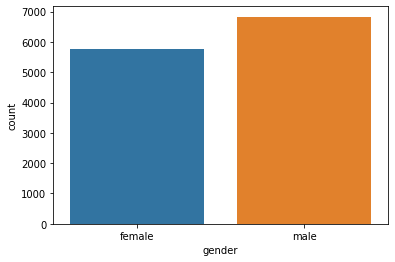

In [ ]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [ ]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)
print("Important Parameters")
print(mean_bone_age)
print(std_bone_age)
print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
Important Parameters
127.3207517246848
41.18202139939618
         id  boneage   male  bone_age_z
0  1377.png      180  False    1.279181
1  1378.png       12  False   -2.800269
2  1379.png       94  False   -0.809109
3  1380.png      120   True   -0.177766
4  1381.png       82  False   -1.100498


Text(0.5, 1.0, 'Number of children in each age group')

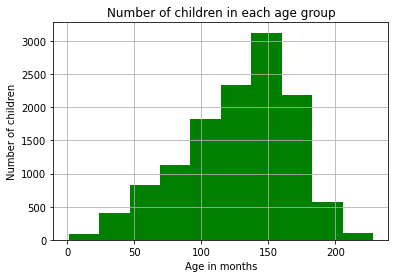

In [ ]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

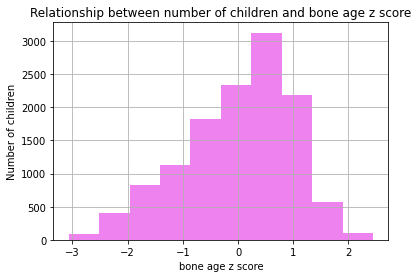

In [ ]:
train_df['bone_age_z'].hist(color = 'violet')
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


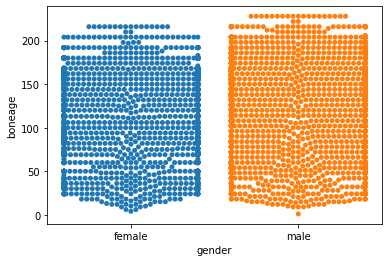

In [ ]:
#Relationship between age and gender with a categorical scatter plot (swarmplot)
sns.swarmplot(x = train_df['gender'], y = train_df['boneage'])

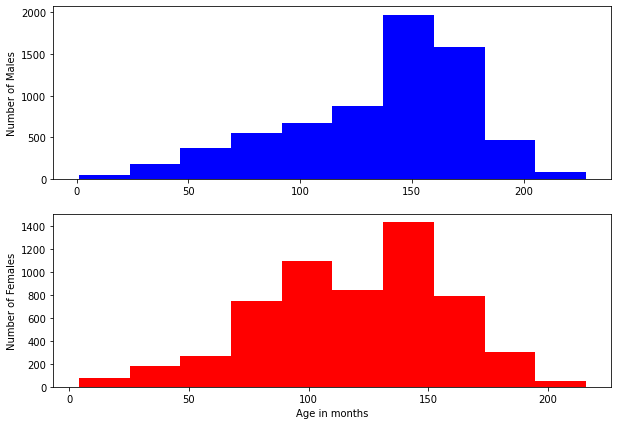

In [ ]:
#distribution of age within each gender 
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of Males')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of Females')
fig.set_size_inches((10,7))

In [ ]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)

Looking into the dataset...

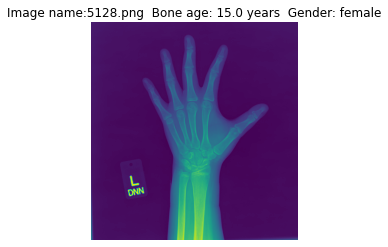

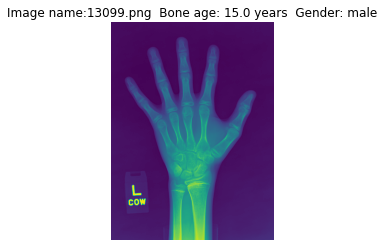

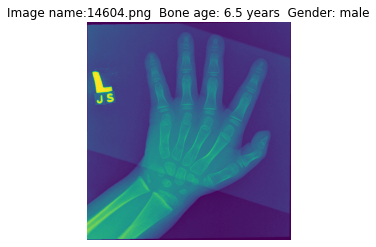

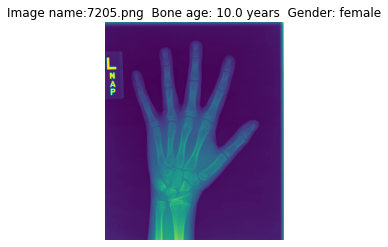

In [ ]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(4).values:
    img = mpimg.imread('/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

**Setting up Image Data Generators!**<br>
We use image data generators for both training, testing and preprocessing of images. Validation set is already broken off from training set. 

In [ ]:
#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = '/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-training-dataset/boneage-training-dataset',
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = '/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-training-dataset/boneage-training-dataset',
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 10088 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 2523 validated image filenames.
Found 0 images belonging to 0 classes.


In [ ]:
#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_dataframe(
    test_df,
    directory = '/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-test-dataset/boneage-test-dataset',
    x_col = 'Case ID',
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 200 validated image filenames.


In [ ]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = '/content/drive/MyDrive/BE_Project/Images/Original_Images/boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            )) 

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 2523 validated image filenames.


 The function to plot training and validation error as a function of epochs

In [ ]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [ ]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential

model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))


#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_2.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_dir = '/content/drive/MyDrive/BE_Project/Logs'
%tensorboard --logdir {logs_dir}

In [ ]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

#model checkpoint
mc = ModelCheckpoint('/content/drive/MyDrive/BE_Project/Model/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]


#fit model
history = model_2.fit_generator(train_generator,
                            steps_per_epoch = 315,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 50,
                            callbacks= callbacks)
history
%tensorboard --logdir logs
plot_it(history)


Evaluating the best saved model on the validation data and visualising results!!

79/79 [==============================] - 21s 169ms/step


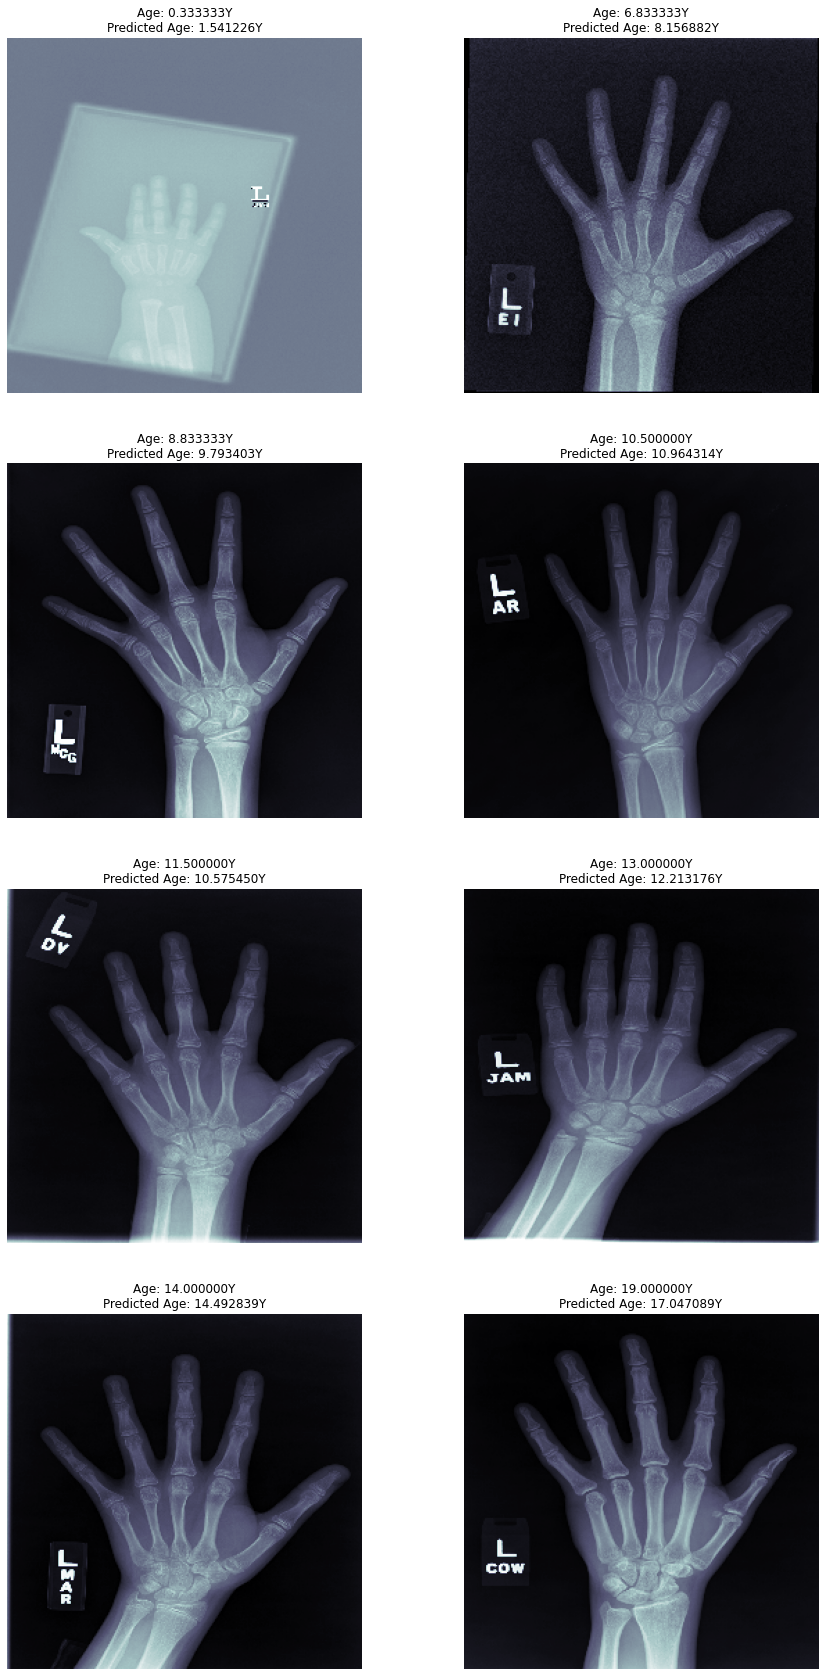

In [ ]:
model_2.load_weights('/content/drive/MyDrive/BE_Project/Model/best_model.h5')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)


Text(0, 0.5, 'Predicted Age (Months)')

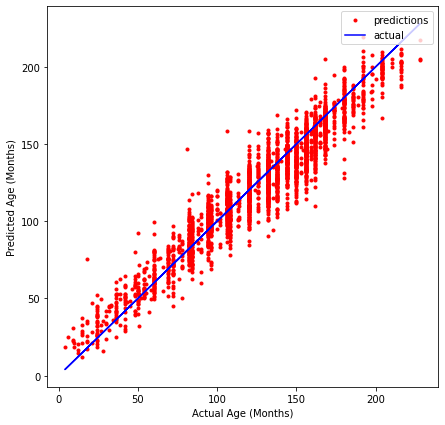

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

**The plot deviates from the line at very old and very young ages probably because we have less examples for those cases in the dataset**

Predicting on test data, we obtain:

In [ ]:
test_generator.reset()
y_pred = model_2.predict(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months/12.0})
results.to_csv("results.csv",index=False)

                                       
                          
                            _____________________________________________________________________________________  
                                              
                                              
                                                        Fingers Crossed, Moment of truth. 
                            
                            
                            -----------------------------------------------------------------------------------

Avoid Using CV2 for preprocessing as ImageDataGenerator and PreProcess Input Function form Keras does a better job.

In [ ]:
import tensorflow as tf
from keras_preprocessing import image

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/BE_Project/Model/best_model.h5', compile=False)
img=tf.keras.preprocessing.image.load_img('/content/second.png',target_size=(256,256))
img=tf.keras.preprocessing.image.img_to_array(img)
img=tf.keras.applications.xception.preprocess_input(img) 

pred = 127.3207517246848 + 41.18202139939618*(new_model.predict(np.array([img])))
print("Age = " + str(pred/12.0) + "Years" )

Age = [[11.230973]]Years
